# Information Retrieval I #
## Assignment 2: retrieval models [100 points + 10 bonus points] ##
**TA**: Christophe Van Gysel (cvangysel@uva.nl; C3.258B, Science Park 904)

**Secondary TAs**: Harrie Oosterhuis, Nikos Voskarides

In this assignment you will get familiar with basic information retrieval concepts. You will implement and evaluate different information retrieval ranking models and evaluate their performance.

We provide you with a VirtualBox image that comes pre-loaded with an index and a Python installation. To query the index, you'll use a Python package ([pyndri](https://github.com/cvangysel/pyndri)) that allows easy access to the underlying document statistics.

For evaluation you'll use the [TREC Eval](https://github.com/usnistgov/trec_eval) utility, provided by the National Institute of Standards and Technology of the United States. TREC Eval is the de facto standard way to compute Information Retrieval measures and is frequently referenced in scientific papers.

This is a **groups-of-two assignment**, the deadline is **23:59 - 25 January, 2017**. Code quality, informative comments and convincing analysis of the results will be considered when grading. Submission should be done through blackboard, questions can be asked on the course [Piazza](https://piazza.com/class/ixoz63p156g1ts).

### Technicalities (must-read!) ###
This assignment comes pre-loaded on a VirtualBox running Ubuntu. We have configured the indexing software and Python environment such that it works out of the box. You are allowed to extract the files from the VirtualBox and set-up your own non-virtualized environment. However, in this case you are on your own w.r.t. software support.

The assignment directory is organized as follows:
   * `./assignment.ipynb` (this file): the description of the assignment.
   * `./index/`: the index we prepared for you.
   * `./ap_88_90/`: directory with ground-truth and evaluation sets:
      * `qrel_test`: test query relevance collection (**test set**).
      * `qrel_validation`: validation query relevance collection (**validation set**).
      * `topics_title`: semicolon-separated file with query identifiers and terms.
      
`Python + Jupyter`, `Indri`, `Gensim` and `Pyndri` come pre-installed (see `$HOME/.local`). TREC Eval can be found in `$HOME/Downloads/trec_eval.9.0`. The password of the `student` account on the VirtualBox is `datascience`.

### TREC Eval primer ###
The TREC Eval utility can be downloaded and compiled as follows:

    git clone https://github.com/usnistgov/trec_eval.git
    cd trec_eval
    make

TREC Eval computes evaluation scores given two files: ground-truth information regarding relevant documents, named *query relevance* or *qrel*, and a ranking of documents for a set of queries, referred to as a *run*. The *qrel* will be supplied by us and should not be changed. For every retrieval model (or combinations thereof) you will generate a run of the top-1000 documents for every query. The format of the *run* file is as follows:

    $query_identifier Q0 $document_identifier $rank_of_document_for_query $query_document_similarity $run_identifier
    
where
   * `$query_identifier` is the unique identifier corresponding to a query (usually this follows a sequential numbering).
   * `Q0` is a legacy field that you can ignore.
   * `$document_identifier` corresponds to the unique identifier of a document (e.g., APXXXXXXX where AP denotes the collection and the Xs correspond to a unique numerical identifier).
   * `$rank_of_document_for_query` denotes the rank of the document for the particular query. This field is ignored by TREC Eval and is only maintained for legacy support. The ranks are computed by TREC Eval itself using the `$query_document_similarity` field (see next). However, it remains good practice to correctly compute this field.
   * `$query_document_similarity` is a score indicating the similarity between query and document where a higher score denotes greater similarity.
   * `$run_identifier` is an identifier of the run. This field is for your own convenience and has no purpose beyond bookkeeping.
   
For example, say we have two queries: `Q1` and `Q2` and we rank three documents (`DOC1`, `DOC2`, `DOC3`). For query `Q1`, we find the following similarity scores `score(Q1, DOC1) = 1.0`, `score(Q1, DOC2) = 0.5`, `score(Q1, DOC3) = 0.75`; and for `Q2`: `score(Q2, DOC1) = -0.1`, `score(Q2, DOC2) = 1.25`, `score(Q1, DOC3) = 0.0`. We can generate run using the following snippet:

In [1]:
import logging
import sys

def write_run(model_name, data, out_f,
              max_objects_per_query=sys.maxsize,
              skip_sorting=False):
    """
    Write a run to an output file.
    Parameters:
        - model_name: identifier of run.
        - data: dictionary mapping topic_id to object_assesments;
            object_assesments is an iterable (list or tuple) of
            (relevance, object_id) pairs.
            The object_assesments iterable is sorted by decreasing order.
        - out_f: output file stream.
        - max_objects_per_query: cut-off for number of objects per query.
    """
    for subject_id, object_assesments in data.items():
        if not object_assesments:
            logging.warning('Received empty ranking for %s; ignoring.',
                            subject_id)

            continue

        # Probe types, to make sure everything goes alright.
        # assert isinstance(object_assesments[0][0], float) or \
        #     isinstance(object_assesments[0][0], np.float32)
        assert isinstance(object_assesments[0][1], str) or \
            isinstance(object_assesments[0][1], bytes)

        if not skip_sorting:
            object_assesments = sorted(object_assesments, reverse=True)

        if max_objects_per_query < sys.maxsize:
            object_assesments = object_assesments[:max_objects_per_query]

        if isinstance(subject_id, bytes):
            subject_id = subject_id.decode('utf8')

        for rank, (relevance, object_id) in enumerate(object_assesments):
            if isinstance(object_id, bytes):
                object_id = object_id.decode('utf8')

            out_f.write(
                '{subject} Q0 {object} {rank} {relevance} '
                '{model_name}\n'.format(
                    subject=subject_id,
                    object=object_id,
                    rank=rank + 1,
                    relevance=relevance,
                    model_name=model_name))
            
# The following writes the run to standard output.
# In your code, you should write the runs to local
# storage in order to pass them to trec_eval.
write_run(
    model_name='example',
    data={
        'Q1': ((1.0, 'DOC1'), (0.5, 'DOC2'), (0.75, 'DOC3')),
        'Q2': ((-0.1, 'DOC1'), (1.25, 'DOC2'), (0.0, 'DOC3')),
    },
    out_f=sys.stdout,
    max_objects_per_query=1000)

Q1 Q0 DOC1 1 1.0 example
Q1 Q0 DOC3 2 0.75 example
Q1 Q0 DOC2 3 0.5 example
Q2 Q0 DOC2 1 1.25 example
Q2 Q0 DOC3 2 0.0 example
Q2 Q0 DOC1 3 -0.1 example


Now, imagine that we know that `DOC1` is relevant and `DOC3` is non-relevant for `Q1`. In addition, for `Q2` we only know of the relevance of `DOC3`. The query relevance file looks like:

    Q1 0 DOC1 1
    Q1 0 DOC3 0
    Q2 0 DOC3 1
    
We store the run and qrel in files `example.run` and `example.qrel` respectively on disk. We can now use TREC Eval to compute evaluation measures. In this example, we're only interested in Mean Average Precision and we'll only show this below for brevity. However, TREC Eval outputs much more information such as NDCG, recall, precision, etc.

    $ trec_eval -m all_trec -q example.qrel example.run | grep -E "^map\s"
    > map                   	Q1	1.0000
    > map                   	Q2	0.5000
    > map                   	all	0.7500
    
Now that we've discussed the output format of rankings and how you can compute evaluation measures from these rankings, we'll now proceed with an overview of the indexing framework you'll use.

### Pyndri primer ###
For this assignment you will use [Pyndri](https://github.com/cvangysel/pyndri) [[1](https://arxiv.org/abs/1701.00749)], a python interface for [Indri](https://www.lemurproject.org/indri.php). We have indexed the document collection and you can query the index using Pyndri. We will start by giving you some examples of what Pyndri can do:

First we read the document collection index with Pyndri:

In [2]:
import pyndri

index = pyndri.Index('index/')

The loaded index can be used to access a collection of documents in an easy manner. We'll give you some examples to get some idea of what it can do, it is up to you to figure out how to use it for the remainder of the assignment.

First let's look at the number of documents, since Pyndri indexes the documents using incremental identifiers we can simply take the lowest index and the maximum document and consider the difference:

In [3]:
print("There are %d documents in this collection." % (index.maximum_document() - index.document_base()))

There are 164597 documents in this collection.


Let's take the first document out of the collection and take a look at it:

Here we see a document consists of two things, a string representing the external document identifier and an integer list representing the identifiers of words that make up the document. Pyndri uses integer representations for words or terms, thus a token_id is an integer that represents a word whereas the token is the actual text of the word/term. Every id has a unique token and vice versa with the exception of stop words: words so common that there are uninformative, all of these receive the zero id.

To see what some ids and their matching tokens we take a look at the dictionary of the index:

Using this dictionary we can see the tokens for the (non-stop) words in our example document:

The reverse can also be done, say we want to look for news about the "University of Massachusetts", the tokens of that query can be converted to ids using the reverse dictionary:

Naturally we can now match the document and query in the id space, let's see how often a word from the query occurs in our example document:

### Parsing the query file
You can parse the query file (`ap_88_89/topics_title`) using the following snippet:

In [4]:
import collections
import io
import logging
import sys

def parse_topics(file_or_files,
                 max_topics=sys.maxsize, delimiter=';'):
    assert max_topics >= 0 or max_topics is None

    topics = collections.OrderedDict()

    if not isinstance(file_or_files, list) and \
            not isinstance(file_or_files, tuple):
        if hasattr(file_or_files, '__iter__'):
            file_or_files = list(file_or_files)
        else:
            file_or_files = [file_or_files]

    for f in file_or_files:
        assert isinstance(f, io.IOBase)

        for line in f:
            assert(isinstance(line, str))

            line = line.strip()

            if not line:
                continue

            topic_id, terms = line.split(delimiter, 1)

            if topic_id in topics and (topics[topic_id] != terms):
                    logging.error('Duplicate topic "%s" (%s vs. %s).',
                                  topic_id,
                                  topics[topic_id],
                                  terms)

            topics[topic_id] = terms

            if max_topics > 0 and len(topics) >= max_topics:
                break

    return topics

### Task 1: Implement and compare lexical IR methods [45 points] ### 

In this task you will implement a number of lexical methods for IR using the **Pyndri** framework. Then you will evaluate these methods on the dataset we have provided using **TREC Eval**.

Use the **Pyndri** framework to get statistics of the documents (term frequency, document frequency, collection frequency; **you are not allowed to use the query functionality of Pyndri**) and implement the following scoring methods in **Python**:

- [TF-IDF](http://nlp.stanford.edu/IR-book/html/htmledition/tf-idf-weighting-1.html). **[5 points]**
- [BM25](http://nlp.stanford.edu/IR-book/html/htmledition/okapi-bm25-a-non-binary-model-1.html) with k1=1.2 and b=0.75. **[5 points]**
- Language models ([survey](https://drive.google.com/file/d/0B-zklbckv9CHc0c3b245UW90NE0/view))
    - Jelinek-Mercer (explore different values of 𝛌 in the range [0.1, 0.2, ..., 0.9]). **[5 points]**
    - Dirichlet Prior (explore different values of 𝛍 [500, 1000, ..., 2000]). **[5 points]**
    - Absolute discounting (explore different values of 𝛅 in the range [0.1, 0.2, ..., 0.9]). **[5 points]**
    - [Positional Language Models](http://sifaka.cs.uiuc.edu/~ylv2/pub/sigir09-plm.pdf) define a language model for each position of a document, and score a document based on the scores of its PLMs. The PLM is estimated based on propagated counts of words within a document through a proximity-based density function, which both captures proximity heuristics and achieves an effect of “soft” passage retrieval. Implement the PLM, all five kernels, but only the Best position strategy to score documents. Use 𝛔 equal to 50, and Dirichlet smoothing with 𝛍 optimized on the validation set (decide how to optimize this value yourself and motivate your decision in the report). **[10 points]**
    
Implement the above methods and report evaluation measures (on the test set) using the hyper parameter values you optimized on the validation set (also report the values of the hyper parameters). Use TREC Eval to obtain the results and report on `NDCG@10`, Mean Average Precision (`MAP@1000`), `Precision@5` and `Recall@1000`.

For the language models, create plots showing `NDCG@10` with varying values of the parameters. You can do this by chaining small scripts using shell scripting (preferred) or execute trec_eval using Python's `subprocess`.

Compute significance of the results using a [two-tailed paired Student t-test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html) **[10 points]**. Be wary of false rejection of the null hypothesis caused by the [multiple comparisons problem](https://en.wikipedia.org/wiki/Multiple_comparisons_problem). There are multiple ways to mitigate this problem and it is up to you to choose one.

Analyse the results by identifying specific queries where different methods succeed or fail and discuss possible reasons that cause these differences.

**NOTE**: Don’t forget to use log computations in your calculations to avoid underflows. 

In [191]:
%matplotlib inline
import matplotlib.pyplot as plt # Needs to be installed
import numpy as np
import scipy
import math
import seaborn as sns # Needs to be installed
from collections import Counter, OrderedDict, defaultdict
import pickle
from functools import partial
import heapq
from operator import itemgetter
import pprofile
import subprocess
import gensim
import cython
import logging
import pyndri.compat
import os
logging.basicConfig(level=logging.INFO)

########## COLLECTING DOCUMENT STATISTICS ################
# Global variables, dictionaries from the index
token2id, id2token, id2df = index.get_dictionary()
id2colfreq = index.get_term_frequencies()
id2colprob = {}
start_index, end_index = index.document_base(), index.maximum_document()
total_docs = end_index - start_index

# Collection length and longest document
longest_doc_length = -1
collection_length = 0
for i in range(start_index, end_index):
    doc = index.document(i)
    collection_length += len(doc[1])
    longest_doc_length = max(longest_doc_length, len(doc[1]))

# Average document length
avg_doc_length = collection_length / total_docs

In [192]:
def preprocess_queries(filename='./ap_88_89/topics_title', raw_terms=False):
    """
    Preprocess queries for O(1) access. 
    From lists of words, to dictionaries 
    of token_ids and their counts, and optionally
    the raw terms used for word2vec/doc2vec, etc.
    """
    with open(filename, 'r') as f_topics:
        queries = parse_topics([f_topics])
    
    processed_queries = OrderedDict()
    global id2colprob
    
    # Preprocessing of all queries
    for query_id in queries:
        query = queries[query_id]

        # Tokenize the query
        tokenized_query = index.tokenize(query)

        # Get token ids for tokens in the query
        token_ids = [token2id.get(token, 0) for token in tokenized_query]

        # Remove stopwords
        token_ids = [t for t in token_ids if t > 0]

        # Construct a dictionary of token_id -> count(token_id) to represent query
        query_terms = Counter(token_ids)
        
        for query_t in query_terms:
            if query_t not in id2colprob:
                id2colprob[query_t] = id2colfreq[query_t] / collection_length
        
        query_info = {'terms': query_terms, 'length':len(query_terms)}
        
        if raw_terms:
            # For word2vec/doc2vec, etc.
            query_info['raw_terms'] = tuple([id2token[t_id] for t_id in query_terms if id2colfreq[t_id] > 5])
        
        processed_queries[query_id] = query_info
    
    return processed_queries

# Get all queries to try models on 
queries = preprocess_queries()

def process_docinfo(document):
    """
    Given a document, returns information used by various
    scoring measures.
    """
    # Hashmap of words and counts for O(1) access
    document_words = Counter(document[1])

    # Frequency of most common word in the document.
    most_common = document_words.most_common(1)[0][1]

    # Length of the document
    doc_length = len(document[1])

    # Normalized document length
    doc_norm_length = doc_length / avg_doc_length

    # Number of unique tokens in the document (i.e. document vocabulary)
    doc_unique = len(document_words)
        
    return {'terms': document_words, 'top_freq':most_common, 'text': document[1],
            'length':doc_length, 'norm_length':doc_norm_length, 'unique':doc_unique, 'outside_id':document[0]}

class TrecEvaluator:
    
    def __init__(self, validation_data, runfile_name="run"):
        self._runfile_name = runfile_name
        self._validation_data = validation_data
        
    def evaluate(self, data, complete=False):
        with open(self._runfile_name, "w") as f:
            write_run(
                model_name=self._runfile_name,
                data=data,
                out_f=f,
                max_objects_per_query=1000)
            
        return self._call_trec_eval_complete() if complete else self._call_trec_eval() 
    
    def _call_trec_eval(self):
        """
        Runs the a shell script which should be present
        in the same folder as the notebook. The script calls trec_eval,
        with the model scores and returns the results.
        
        Returns only overall results.
        """
        cmd = ['./run_trec_eval.sh', self._validation_data, self._runfile_name]
        result = {}
        try:
            p = subprocess.Popen(cmd, stdout=subprocess.PIPE)
            for line in p.stdout:
                frags = line.decode().strip().split()
                result[frags[0]] = float(frags[2])
            p.wait()
        except Exception as e:
            print('Error executing evaluation script. ', e)
            print('If you are getting permission error from subprocess, use "chmod +x run_trec_eval.sh"')
        return result
    
    def _call_trec_eval_complete(self):
        """
        Returns the results for each query
        as well as general results.
        
        Note: Please use chmod +x run_complete_trec_eval.sh if 
        you are running into Permission errors.
        """
        cmd = ['./run_complete_trec_eval.sh', self._validation_data, self._runfile_name]
        result = {}
        p = subprocess.Popen(cmd, stdout=subprocess.PIPE)
        for line in p.stdout:
            frags = line.decode().strip().split()
            if frags[1] in result:
                result[frags[1]].append({frags[0]: float(frags[2])})
            else:
                result[frags[1]] = [{frags[0]:float(frags[2])}]
            p.wait()
        return result

# Evaluators for test and validation set.
trec_eval = TrecEvaluator(validation_data="ap_88_89/qrel_validation")
trec_eval_test = TrecEvaluator(validation_data="ap_88_89/qrel_test")

### TF-IDF 

In [193]:
def augmented_termfreq(document, token_id, max_frequency):
    """
    Returns augmented term frequency of a word in the document.
    To prevent bias towards larger documents, we divide the 
    raw term frequency by the maximum raw term frequency of any
    term in the document.
    
    Reference:
    http://nlp.stanford.edu/IR-book/html/htmledition/maximum-tf-normalization-1.html
    
    Args:
    - document: A collections.Counter dictionary that maps token_ids to their counts.
    - token_id: The unque id of the term, in the collection.
    - max_frequency: The maximum raw frequency found in the document.
    """
    term_count = document.get(token_id, 0)
    
    # Handle 0 case
    if term_count == 0:
        return 0
    
    # Return augmented term frequency with smoothing of a = 0.4
    # Alternative possible value is 0.5.
    return 0.4 + 0.6 * (term_count / max_frequency)

def inverse_docfreq(token_id):
    """
    Returns the inverse document frequency of the term.
    
    Args:
    - token_id: The unique id of the term, in the collection.
    """
    df = id2df.get(token_id, 0)
    return np.log(total_docs / df)

def tf_idf(doc, query, token_id):
    """
    Returns the term-frequency inverse document frequency of a term,
    in a document. Calculated as tf(t,d) * idf(t,D).
    
    Args:
    - doc: Dictionary containing document information.
    - query: Dictionary containing query information.
    - token_id: The unque id of the term, in the collection.
    """
    # Compute augmented term frequency
    term_freq = augmented_termfreq(doc['terms'], token_id, doc['top_freq'])
    
    if term_freq == 0:
        return 0
    
    # Compute inverse document frequency
    idf = inverse_docfreq(token_id)
    
    return term_freq * idf

### BM25 ($k_1 = 1.2$, $b = 0.75$)

In [194]:
def bm25(doc, query, token_id):
    """
    Computes the overal bm25 score which involves
    computing the okapi frequency and multiplying it with the
    IDF. This method serves as an 'interface' shared by the task 1
    scoring methods.
    
    Args:
    - doc: Dictionary containing document information.
    - query: Dictionary containing query information.
    - token_id: The unque id of the term, in the collection.
    """
    return bm25_score(doc['terms'], token_id, doc['norm_length'])

def okapi_frequency(doc_terms, token_id, norm_length, k1, b):
    """
    Returns the okapi frequency of a term, given the hyperparameters
    k1 and b.
    
    Args:
    - doc_terms: Dictionary with the terms in the document, and their counts as values.
    - token_id: The unque id of the term, in the collection.
    - norm_length: Normalized length of the document (i.e. already divided by avg doc length.)
    - k1,b: Hyperparameters tuning the importance of term count, doc length.
    """
    term_count = doc_terms.get(token_id, 0)
    return ((k1 + 1) * term_count) / (k1 * ((1 - b) + b * norm_length) + term_count)

def bm25_score(doc_terms, token_id, norm_length, k1=1.2, b=0.75):
    """
    Computes overal bm 25 score.
    
    Args:
    - doc_terms: Dictionary with the terms in the document, and their counts as values.
    - token_id: The unque id of the term, in the collection.
    - norm_length: Normalized length of the document (i.e. already divided by avg doc length.)
    - k1,b: Hyperparameters tuning the importance of term count, doc length.
    """
    return okapi_frequency(doc_terms, token_id, norm_length, k1, b) * inverse_docfreq(token_id)

### Language models

General formula for computing scores given a document language model and query is:

$$log P(q|d) = \sum_{tf(q_i, d) > 0} log \dfrac{P_s (q_i | d)}{\alpha_d \cdot P(q_i | C)} + n \cdot log \alpha_d$$

where: 

- $\alpha_d$ is a document dependent constant related to how much probability to allocate to unseen words, according to *a particular smoothing method.*
- $P_s(q_i | d)$ is the probability of seeing the respective word given the smoothed document language model.
- $n$ is the length of the query.
- $P(q_i | C)$ is the probability of the word given the collection language model, which will simply be $\dfrac{tf(q_i, C)}{\|C\|}$

In [195]:
def jelinek_score(doc, query, token_id, lmbda=0.5):
    """
    'Interface' method with common parameters shared by scoring methods.
    Call this method to compute the jelinek smoothed score of a language model
    given a document, query and term (token) id.
    """
    term_doc_prob = doc['terms'].get(token_id, 0) / doc['length']
    term_col_prob = id2colfreq[token_id] / collection_length
    return jelinek_mercer(term_doc_prob, term_col_prob, lmbda)

def jelinek_mercer(term_doc_prob, term_col_prob, doc_length, lmbda=0.5):
    """
    Computes and returns the score of a query-document-term pair given a document language model
    defined using the Jelinek-Mercer smoothing method.
    
    Ps = (1 - lambda) * document_prob + lambda * collection_prob
    alpha_d = lambda
    
    Args:
    - term_doc_prob: tf(q_i, d) / |d|. The unsmoothed estimate for the term in the document.
    - term_col_prob: tf(q_i, C) / |C|. The term collection probability.
    - doc_length: |d| - Total length of the document we are computing the score for.
    - lmbda: Jelinek-Mercer interpolation parameter.
    """
    # Collection smoothing.
    collection_model = lmbda * term_col_prob
    
    # Smoothed seen probabililty.
    seen_prob = ((1.-lmbda) * term_doc_prob) + collection_model
    
    # Final document score.
    return np.log(seen_prob)

In [196]:
def dirichlet_score(doc, query, token_id, mu=500):
    """
    Returns score for a languge model smoothed using dirichlet prior.
    """
    term_doc_prob = doc['terms'].get(token_id, 0) / doc['length']
    term_col_prob = id2colfreq[token_id] / collection_length
    return dirichlet_smoothing(doc['terms'].get(token_id, 0), term_col_prob, doc['length'], query['length'], mu)

def dirichlet_smoothing(term_doc_freq, term_col_prob, doc_length, query_length, mu=500):
    """
    Score of a query-document pair given a document language model defined
    using a Dirichlet Prior for smoothing.
    
    Args:
    - term_doc_prob: tf(q_i, d) / |d|. The unsmoothed estimate for the term in the document.
    - term_col_prob: tf(q_i, C) / |C|. The term collection probability.
    - doc_length: |d| - Total length of the document we are computing the score for.
    - query_length: Length of the query.
    - mu: Dirichlet parameter.
    """
    alpha_d = mu / (doc_length + mu)
    
    # Collection smoothing.
    collection_model = alpha_d * term_col_prob
    
    # Smoothed seen probability
    seen_prob = (term_doc_freq  + (mu * term_col_prob)) / (doc_length + mu)
    
    return np.log(seen_prob)

In [197]:
def abs_score(doc, query, token_id, delta=0.5):
    """
    Return Absolute discount score.
    """
    term_col_prob = id2colfreq[token_id] / collection_length
    
    return abs_disc(doc['terms'].get(token_id, 0), term_col_prob, doc['length'], doc['unique'], query['length'], delta)

def abs_disc(term_doc_freq, term_col_prob, doc_length, doc_unique, query_length, delta=0.5):
    """
    Score of a query-document pair given a document language model defined
    using Absolute Discounting for smoothing.
    
    Args:
    - term_doc_freq: tf(q_i, d). The number of occurances of the term in the document.
    - term_col_prob: tf(q_i, C) / |C|. The term collection probability.
    - doc_length: |d| - Total length of the document we are computing the score for.
    - doc_unique: |d|_u - Number of unique tokens in the document.
    - query_length: Length of the query.
    - delta: Absolute discounting parameter.
    """
    alpha_d = (delta * doc_unique) / doc_length
    
    # Collection
    collection_model = alpha_d * term_col_prob
    
    # Smoothed doc prob
    seen_prob = (max(term_doc_freq - delta, 0) / doc_length) + collection_model
    
    return np.log(seen_prob)

### Computing scores for each measure

In [198]:
def compute_score(doc, query, measure_func):
    score = 0
    for token_id in query['terms']:
        score += measure_func(doc=doc, query=query, token_id=token_id)
    return score

def compute_measure(queries, measure_functions, verbose=True):
    """
    Computes the score for every query-document pair
    that have any word in common, using the 'measure_func'
    function.
    
    Returns a dictionary where for each query_id the 
    values is an array with the top 1000 documents ranked
    by their score according to 'measure_func'.
    
    Args:
    - queries: Dictionary with key 'query_id' and values as dicts
    of the terms in the query and their counts.
    - documents: OrderedDict with keys 'doc_id' and processed docs as values.
    - measure_functions: Measure functions that recieve a query and a document
    and returns the score according to some predefined metric (e.g. tf-idf, etc.)
    """
    # Initialize scores for all measurement functions
    funcscores = []
    for x in range(len(measure_functions)):
        funcscores.append(defaultdict(list))
    
    for doc_id in range(start_index, end_index):
        if verbose and doc_id % 10000 == 0:
            print("Processed {0} documents.".format(doc_id))
            
        doc = index.document(doc_id)
        
        if len(doc[1]) == 0:
            continue
            
        document_info = process_docinfo(doc)

        # For every query we have, compute the document score.
        for query_id in queries:
            query_info = queries[query_id]
            
            ### SIMPLIFYING ASSUMPTION ###
            # If no words in common between query-doc, skip.
            # This will leave only 6 queries, with < 1000 docs
            # However all ranked documents will actually be relevant
            # to the query. Please see paper for further details.
            if len(set(query_info['terms']).intersection(document_info['terms'])) == 0:
                continue
            
            # Compute and store scores for each measure.
            for func_index, measure_func in enumerate(measure_functions):
                # Score for current doc-query pair.
                pair_score = compute_score(document_info, query_info, measure_func)
                curr_score = funcscores[func_index]
                curr_score[query_id].append((pair_score, document_info['outside_id']))
    
    for score in funcscores:
        for query_id in score:
            score[query_id] = heapq.nlargest(1000, score[query_id], itemgetter(0))
    
    return funcscores

# Save scores for later analysis, so we don't recompute/ hold in memory.
tf_file = 'tfidf_scores.p'
bm25_file = 'bm25_scores.p'

In [ ]:
# Compute scores for models that do not need hyperparameter optimization
# i.e. tfidf and bm25.
simple_scores = compute_measure(queries, measure_functions=[tf_idf, bm25])
tfidfscore, bm25score = simple_scores[0], simple_scores[1]

In [179]:
print('TF_IDF Validation set score is {0}'.format(trec_eval.evaluate(data=tfidfscore)))
print('BM25 Validation set score is {0}'.format(trec_eval.evaluate(data=bm25score)))
print('TF_IDF Test set score is {0}'.format(trec_eval_test.evaluate(data=tfidfscore)))
print('BM25 Test set score is {0}'.format(trec_eval_test.evaluate(data=bm25score)))

TF_IDF Validation set score is {'ndcg_cut_10': 0.349, 'recall_1000': 0.5749, 'P_5': 0.3467, 'map_cut_1000': 0.209}
BM25 Validation set score is {'ndcg_cut_10': 0.3896, 'recall_1000': 0.6626, 'P_5': 0.3933, 'map_cut_1000': 0.24}
TF_IDF Test set score is {'ndcg_cut_10': 0.3428, 'recall_1000': 0.6089, 'P_5': 0.3567, 'map_cut_1000': 0.1829}
BM25 Test set score is {'ndcg_cut_10': 0.4109, 'recall_1000': 0.6493, 'P_5': 0.4217, 'map_cut_1000': 0.2183}


In [180]:
with open(tf_file, 'wb') as fp:
    pickle.dump(tfidfscore, fp)
    
with open(bm25_file, 'wb') as fp:
    pickle.dump(bm25score, fp)

In [191]:
# Free memory
%reset_selective -f simple_scores
%reset_selective -f tfidfscore
%reset_selective -f bm25score

##### Optimizing hyperparameters for smoothed language models

- We can optimize these parameters using either grid-search or a two-stage smoothing model. The former is implemented below for a range of values (it's essentially grid search with result evaluation on the validation set). The latter was not implemented due to time constraints.

In [23]:
# Grid search for Jelinek Mercer
lambdas = np.arange(0.1,1.0,0.1)
jelinek_funcs = [partial(jelinek_score, lmbda=lmbda_value) for lmbda_value in lambdas]
jelinek_scores = compute_measure(queries, measure_functions=jelinek_funcs)

Processed 10000 documents.
Processed 20000 documents.
Processed 30000 documents.
Processed 40000 documents.
Processed 50000 documents.
Processed 60000 documents.
Processed 70000 documents.
Processed 80000 documents.
Processed 90000 documents.
Processed 100000 documents.
Processed 110000 documents.
Processed 120000 documents.
Processed 130000 documents.
Processed 140000 documents.
Processed 150000 documents.
Processed 160000 documents.


In [29]:
jelinek_trec_scores = []
for i, score in enumerate(jelinek_scores):
    trec_score = trec_eval.evaluate(data=score)
    # Show score
    print('Jelinek score for lambda {0} is {1}'.format(lambdas[i], trec_score))
    trec_score['lambda'] = lambdas[i]
    jelinek_trec_scores.append(trec_score)
    
# Save to not compute again
jelinek_file = 'jelinek_validation.p'
with open(jelinek_file, 'wb') as fp:
    pickle.dump(jelinek_trec_scores, fp)

Jelinek score for lambda 0.1 is {'P_5': 0.36, 'recall_1000': 0.6091, 'ndcg_cut_10': 0.3658, 'map_cut_1000': 0.2157}
Jelinek score for lambda 0.2 is {'P_5': 0.3733, 'recall_1000': 0.6137, 'ndcg_cut_10': 0.3736, 'map_cut_1000': 0.2181}
Jelinek score for lambda 0.30000000000000004 is {'P_5': 0.3733, 'recall_1000': 0.6257, 'ndcg_cut_10': 0.3683, 'map_cut_1000': 0.2187}
Jelinek score for lambda 0.4 is {'P_5': 0.3933, 'recall_1000': 0.6298, 'ndcg_cut_10': 0.3759, 'map_cut_1000': 0.2197}
Jelinek score for lambda 0.5 is {'P_5': 0.38, 'recall_1000': 0.6372, 'ndcg_cut_10': 0.3698, 'map_cut_1000': 0.2194}
Jelinek score for lambda 0.6 is {'P_5': 0.3867, 'recall_1000': 0.6353, 'ndcg_cut_10': 0.3715, 'map_cut_1000': 0.2199}
Jelinek score for lambda 0.7000000000000001 is {'P_5': 0.3733, 'recall_1000': 0.6337, 'ndcg_cut_10': 0.3788, 'map_cut_1000': 0.2201}
Jelinek score for lambda 0.8 is {'P_5': 0.3867, 'recall_1000': 0.634, 'ndcg_cut_10': 0.3823, 'map_cut_1000': 0.2204}
Jelinek score for lambda 0.9 i

In [215]:
# Load and plot jelinek scores for all parameter values
# And select best model

# This is last minute, so a bit contrived.
pos = {lmbda:position for position, lmbda in enumerate(lambdas)}

with open('jelinek_validation.p', 'rb') as fp:
    jelinek_all_scores = pickle.load(fp)
    
jelinek_ndcg_10 = [0] * len(jelinek_all_scores)

for score in jelinek_all_scores:
    pos = lambdas.index(score['lambda'])
    jelinek_ndcg_10[pos] = score['ndcg_cut_10']
    
best_ndcg = max(jelinek_ndcg_10)
best_lambda = lambdas[jelinek_ndcg_10.index(max(jelinek_ndcg_10))]
print('Best Jelinek-Mercer score using NDCG is {0} with lambda of {1}'.format(best_ndcg, best_lambda))

Best Jelinek-Mercer score using NDCG is 0.3868 with lambda of 0.9


In [214]:
# # Recompute Jelinek-Mercer module with best lambda, and present results on test set.
best_jelinek_score = compute_measure(queries, measure_functions=[partial(jelinek_score, lmbda=best_lambda)], verbose=False)
with open('best_jelinek_scores.p', 'wb') as fp:
    pickle.dump(best_jelinek_score[0], fp)

print('Test set results of jelinek optimized on validation set are: \n')
print(trec_eval_test.evaluate(data=best_jelinek_score[0]))

Test set results of jelinek optimized on validation set are: 

{'recall_1000': 0.6288, 'P_5': 0.375, 'ndcg_cut_10': 0.3849, 'map_cut_1000': 0.1977}


In [44]:
# Clean memory
%reset # Note: you need to rerun some initial functions.

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [69]:
# Grid search for Dirichlet Prior
mus = np.arange(500,2500,500)
dirichlet_funcs = [partial(dirichlet_score, mu=mu_value) for mu_value in mus]
dirichlet_scores = compute_measure(queries, measure_functions=dirichlet_funcs)

Processed 10000 documents.
Processed 20000 documents.
Processed 30000 documents.
Processed 40000 documents.
Processed 50000 documents.
Processed 60000 documents.
Processed 70000 documents.
Processed 80000 documents.
Processed 90000 documents.
Processed 100000 documents.
Processed 110000 documents.
Processed 120000 documents.
Processed 130000 documents.
Processed 140000 documents.
Processed 150000 documents.
Processed 160000 documents.


In [70]:
dirichlet_trec_scores = []
for i, score in enumerate(dirichlet_scores):
    trec_score = trec_eval.evaluate(data=score)
    # Show score
    print('Dirichlet score for mu {0} is {1}'.format(mus[i], trec_score))
    trec_score['mu'] = mus[i]
    dirichlet_trec_scores.append(trec_score)
    
# Save to not compute again
dirichlet_file = 'dirichlet_validation.p'
with open(dirichlet_file, 'wb') as fp:
    pickle.dump(dirichlet_trec_scores, fp)

Dirichlet score for mu 500 is {'P_5': 0.4067, 'recall_1000': 0.6203, 'ndcg_cut_10': 0.3936, 'map_cut_1000': 0.232}
Dirichlet score for mu 1000 is {'P_5': 0.4, 'recall_1000': 0.6305, 'ndcg_cut_10': 0.404, 'map_cut_1000': 0.2397}
Dirichlet score for mu 1500 is {'P_5': 0.4, 'recall_1000': 0.636, 'ndcg_cut_10': 0.4024, 'map_cut_1000': 0.2406}
Dirichlet score for mu 2000 is {'P_5': 0.3933, 'recall_1000': 0.6302, 'ndcg_cut_10': 0.3998, 'map_cut_1000': 0.2406}


In [217]:
# Load and plot dirichlet scores for all parameter values
# And select best model.
mus = list(np.arange(500,2500,500))
pos = {mu:position for position, mu in enumerate(mus)}

# Fetch dirichlet scores
with open('dirichlet_validation.p', 'rb') as fp:
    dirichlet_all_scores = pickle.load(fp)

# Get best mu.
dirichlet_ndcg_10 = [0] * len(dirichlet_all_scores)

for score in dirichlet_all_scores:
    pos = mus.index(score['mu'])
    dirichlet_ndcg_10[pos] = score['ndcg_cut_10']

# Show best mu.
best_ndcg = max(dirichlet_ndcg_10)
best_mu = mus[dirichlet_ndcg_10.index(max(dirichlet_ndcg_10))]
print('Best Dirichlet score using NDCG is {0} with mu of {1}'.format(best_ndcg, best_mu))

Best Dirichlet score using NDCG is 0.404 with mu of 1000


In [219]:
# Recompute Dirichlet Prior module with best mu, and present results on test set.
best_dirichlet_score = compute_measure(queries, measure_functions=[partial(dirichlet_score, mu=best_mu)], verbose=False)
with open('best_dirichlet_scores.p', 'wb') as fp:
    pickle.dump(best_dirichlet_score[0], fp)

print('Test set results of dirichlet optimized on validation set are: \n')
print(trec_eval_test.evaluate(data=best_dirichlet_score[0]))

Test set results of dirichlet optimized on validation set are: 

{'recall_1000': 0.6313, 'P_5': 0.4283, 'ndcg_cut_10': 0.4139, 'map_cut_1000': 0.2119}


In [72]:
%reset # Note: you need to rerun initial functions.

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [90]:
# Grid search for Absolute Discounting
deltas = np.arange(0.1,1.0,0.1)
abs_funcs = [partial(abs_score, delta=delta_value) for delta_value in deltas]
abs_scores = compute_measure(queries, measure_functions=abs_funcs)

Processed 10000 documents.
Processed 20000 documents.
Processed 30000 documents.
Processed 40000 documents.
Processed 50000 documents.
Processed 60000 documents.
Processed 70000 documents.
Processed 80000 documents.
Processed 90000 documents.
Processed 100000 documents.
Processed 110000 documents.
Processed 120000 documents.
Processed 130000 documents.
Processed 140000 documents.
Processed 150000 documents.
Processed 160000 documents.


In [91]:
abs_trec_scores = []
for i, score in enumerate(abs_scores):
    trec_score = trec_eval.evaluate(data=score)
    # Show score
    print('Absolute Discounting score for delta {0} is {1}'.format(deltas[i], trec_score))
    trec_score['delta'] = deltas[i]
    abs_trec_scores.append(trec_score)
    
# Save to not compute again
abs_file = 'absdisc_validation.p'
with open(abs_file, 'wb') as fp:
    pickle.dump(abs_trec_scores, fp)

Absolute Discounting score for delta 0.1 is {'P_5': 0.3533, 'recall_1000': 0.604, 'ndcg_cut_10': 0.3548, 'map_cut_1000': 0.2121}
Absolute Discounting score for delta 0.2 is {'P_5': 0.3667, 'recall_1000': 0.6023, 'ndcg_cut_10': 0.3705, 'map_cut_1000': 0.2146}
Absolute Discounting score for delta 0.30000000000000004 is {'P_5': 0.3933, 'recall_1000': 0.609, 'ndcg_cut_10': 0.3635, 'map_cut_1000': 0.2167}
Absolute Discounting score for delta 0.4 is {'P_5': 0.3933, 'recall_1000': 0.6236, 'ndcg_cut_10': 0.3641, 'map_cut_1000': 0.2189}
Absolute Discounting score for delta 0.5 is {'P_5': 0.4067, 'recall_1000': 0.6292, 'ndcg_cut_10': 0.3645, 'map_cut_1000': 0.2203}
Absolute Discounting score for delta 0.6 is {'P_5': 0.4133, 'recall_1000': 0.6412, 'ndcg_cut_10': 0.3637, 'map_cut_1000': 0.2221}
Absolute Discounting score for delta 0.7000000000000001 is {'P_5': 0.3933, 'recall_1000': 0.6504, 'ndcg_cut_10': 0.3673, 'map_cut_1000': 0.2234}
Absolute Discounting score for delta 0.8 is {'P_5': 0.3867, '

In [224]:
# Load and plot Abs Discounting scores for all parameter values
# And select best model.
deltas = list(np.arange(0.1,1.0,0.1))
pos = {delta:position for position, delta in enumerate(deltas)}

# Fetch absolute discounting scores
with open('absdisc_validation.p', 'rb') as fp:
    absdisc_all_scores = pickle.load(fp)

# Get best delta.
absdisc_ndcg_10 = [0] * len(absdisc_all_scores)

for score in absdisc_all_scores:
    pos = deltas.index(score['delta'])
    absdisc_ndcg_10[pos] = score['ndcg_cut_10']

# Show best mu.
best_ndcg = max(absdisc_ndcg_10)
best_delta = deltas[absdisc_ndcg_10.index(max(absdisc_ndcg_10))]
print('Best Abs Discounting score using NDCG is {0} with delta of {1}'.format(best_ndcg, best_delta))

Best Abs Discounting score using NDCG is 0.3763 with delta of 0.9


In [223]:
# Recompute Abs Disc. module with best mu, and present results on test set.
best_absdisc_score = compute_measure(queries, measure_functions=[partial(abs_score, delta=best_delta)], verbose=False)
with open('best_absdisc_scores.p', 'wb') as fp:
    pickle.dump(best_absdisc_score[0], fp)

print('Test set results of abs discounting optimized on validation set are: \n')
print(trec_eval_test.evaluate(data=best_absdisc_score[0]))

Test set results of abs discounting optimized on validation set are: 

{'recall_1000': 0.6258, 'P_5': 0.4017, 'ndcg_cut_10': 0.396, 'map_cut_1000': 0.2037}


/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


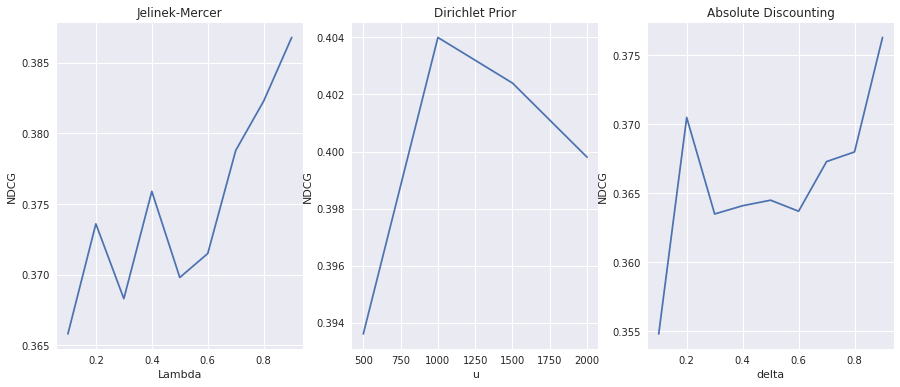

In [240]:
## Plots
f = plt.figure()
f.set_size_inches((15, 6))
ax1 = plt.subplot(1, 3, 1)

lamb = np.arange(0.1, 1.0, 0.1)

ax1.plot(lamb, jelinek_ndcg_10)

ax1.grid(True)

# plt.ylim((0.24, 0.34))
plt.ylabel('NDCG')
plt.xlabel('Lambda')
plt.title('Jelinek-Mercer')

ax2 = plt.subplot(1, 3, 2)

mus = np.arange(500,2500,500)

ax2.plot(mus, dirichlet_ndcg_10)

# plt.ylim((0.24, 0.34))
plt.ylabel('NDCG')
plt.xlabel('u')
plt.title('Dirichlet Prior')
ax2.grid(True)

ax3 = plt.subplot(1, 3, 3)

delta = np.arange(0.1, 1.0, 0.1)

ax3.plot(delta, absdisc_ndcg_10)

# plt.ylim((0.24, 0.34))
plt.ylabel('NDCG')
plt.xlabel('delta')
plt.title('Absolute Discounting')
ax3.grid(True)

plt.show()

In [92]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


#### Positional Language Model

- The main bottleneck of PLM is the computation of the Zi's, but as the author of the paper suggests, a Z_i can be calculated easily using an integration over the entire document space, which gives a form dependent on the cumulative distribution of each kernel function. Below are the final implementations of this integration and it's resultant form for each kernel, furthermore I also show that the sum computed normally is equal to the one computed using this implementation. 

**Note**: For the Gaussian kernel I use the Abramowitz and Stegun approximation of the cumulative normal distribution. This approximation is very good, as there seems to be only extremely minor differences. This does not affect ranking and can be seen after the implementations of the algorithm.

Other optimizations performed: 
- I don't use the entire dataset, only the top 1k from the TF-IDF scoring, which will also help to compare as a baseline. This is motivated by the fact that I can still show a complete correct implementation of the model, but reduce the scale for computational purposes.

In [13]:
def triangle_kernel(i, j, sigma=50.0):
    distance = abs(i - j)
    return 1 - distance / sigma if distance <= sigma else 0

def gaussian_kernel(i, j, sigma=50.0):
    return np.exp(-(i - j) ** 2 / (2 * sigma ** 2))

def cosine_kernel(i, j, sigma=50.0):
    distance = abs(i - j)
    return 0.5  + 0.5 * np.cos(distance * np.pi / sigma) if distance <= sigma else 0

def circle_kernel(i, j, sigma=50.0):
    distance = abs(i - j)
    return np.sqrt(1 - (distance / sigma) ** 2) if distance <= sigma else 0

def passage_kernel(i, j, sigma=50.0):
    distance = abs(i - j)
    return 1 if distance <= sigma else 0

In [14]:
## Cumulative distirbution functions for the kernels.

def triangle_CDF(x, mean, sigma=50):
    res = 0
    x = (x - mean) / float(sigma)
    if x >= 1:
        res = sigma
    elif x < -1:
        res = 0
    elif x < 0:
        res = sigma * (1 - abs(x)) * (1 - abs(x)) / 2.0
    else:
        res = sigma - sigma * (1 - x) * (1 - x) / 2.0
    return res

def gaussian_CDF(x, mean, sigma=50):
    # Abramowitz and Stegun approximation.
    res = 0.0
    x = (x - mean) / float(sigma)
    if x == 0:
        res = 0.5
    else:
        oor_2_pi = 1.0 / (np.sqrt(2.0 * np.pi))
        t = 1.0 / (1.0 + 0.2316419 * abs(x))
        t *= oor_2_pi * np.exp(-0.5 * x * x) * (0.31938153   + t * (-0.356563782 + t * (1.781477937  + t * (-1.821255978 + t * 1.330274429))))
        if x >= 0:
            res = 1.0 - t
        else:
            res = t
    return res

def cosine_CDF(x, mean, sigma=50):
    res = 0
    x = (x - mean) / sigma
    if x >= 1:
        res = sigma
    elif x < -1:
        res = 0
    elif x < 0:
        res = sigma * (1 + x - np.sin(np.pi * x) / np.pi) / 2.0
    else:
        res = sigma - sigma * (1 - x + np.sin(np.pi * x) / np.pi) / 2.0
    
    return res

def circle_CDF(x, mean, sigma=50):
    res = 0
    x = (x - mean) / sigma
    if x >= 1:
        res = sigma * (np.pi / 2.0)
    elif x < -1:
        res = 0
    elif x < 0:
        res = sigma * (math.asin(x) + np.pi / 2.0 - np.sqrt(1 - x * x))
    else:
        res = (np.pi * 2.0) * sigma - sigma * (math.asin(-x) + np.pi / 2.0 - np.sqrt(1 - x * x))
    return res

In [15]:
# These functions help compute Z_is directly using 
# cumulative distribution functions defined in previous cell.
# (or their approximation - gaussian)
# (and just a basic algo for the passage kernel)

def triangle_normalization(position, doc_length, sigma):
    return triangle_CDF(doc_length, position, sigma) - triangle_CDF(0.0, position, sigma)

def gaussian_normalization(position, doc_length, sigma):
    return np.sqrt(2.0 * np.pi) * sigma * (gaussian_CDF(doc_length-1, position, sigma) - gaussian_CDF(0.0, position, sigma))

def cosine_normalization(position, doc_length, sigma):
    return cosine_CDF(doc_length, position, sigma) - cosine_CDF(0.0, position, sigma)

def circle_normalization(position, doc_length, sigma):
    return circle_CDF(doc_length, position, sigma) - circle_CDF(0.0, position, sigma)

def passage_normalization(position, doc_length, sigma=50):
    psg = 0
    if sigma > doc_length - position:
        psg += doc_length - position
    else:
        psg += sigma
        
    if sigma > position:
        psg += position
    else:
        if position > sigma:
            psg += sigma + 1
        else:
            psg += sigma
        
    return psg

In [16]:
## CDF normalization is done to compute Z_i's faster.
## Testing some values for correctness:

sigma = 50
positions = [50, 125, 250]
doc_length = 500

for pos in positions:
    print('Gaussian')
    print(sum([gaussian_kernel(pos,j,sigma) for j in range(1, doc_length + 1)]))
    print(gaussian_normalization(pos, doc_length, sigma))

    print('\nCosine')
    print(sum([cosine_kernel(pos,j,sigma) for j in range(1, doc_length + 1)]))
    print(cosine_normalization(pos, doc_length, sigma))
    
    print('\nCircle')
    print(sum([circle_kernel(pos,j,sigma) for j in range(1, doc_length + 1)]))
    print(circle_normalization(pos, doc_length, sigma))

    print('\nTriangle')
    print(sum([triangle_kernel(pos,j,sigma) for j in range(1, doc_length + 1)]))
    print(triangle_normalization(pos, doc_length, sigma))

    print('\nPassage')
    print(sum([passage_kernel(pos,j,sigma) for j in range(1, doc_length + 1)]))
    print(passage_normalization(pos, doc_length, sigma))
    print('------')

Gaussian
105.142650233
105.446925755

Cosine
50.0
50.0

Circle
78.4567127775
78.5398163397

Triangle
50.0
50.0

Passage
100
100
------
Gaussian
124.530996064
124.553145777

Cosine
50.0
50

Circle
78.4567127775
78.53981633974483

Triangle
50.0
50

Passage
101
101
------
Gaussian
125.331341817
125.331337841

Cosine
50.0
50

Circle
78.4567127775
78.53981633974483

Triangle
50.0
50

Passage
101
101
------


In [19]:
# Compute all kernel operations beforehand
# by computing a kernel matrix of the maximum document length
# for each kernel operation. This ensures that now any k(i,j) is O(1)
g_matrix = np.zeros((longest_doc_length,longest_doc_length))
circle_matrix = np.zeros((longest_doc_length,longest_doc_length))
passage_matrix = np.zeros((longest_doc_length,longest_doc_length))
cosine_matrix = np.zeros((longest_doc_length,longest_doc_length))
triangle_matrix = np.zeros((longest_doc_length,longest_doc_length))

for x in range(longest_doc_length):
    for y in range(longest_doc_length):
        g_matrix[x][y] = gaussian_kernel(x,y)
        circle_matrix[x][y] = circle_kernel(x,y)
        passage_matrix[x][y] = passage_kernel(x,y)
        cosine_matrix[x][y] = cosine_kernel(x,y)
        triangle_matrix[x][y] = triangle_kernel(x,y)
        
# Note: Later I realized that if you do a blocksize sum (G[i,0:N]), you can actually compute Zi using the matrix,
# but I had already done some of the integrations for the CDF so I will use that method. 
# performance should be similar.

In [31]:
def load_tfidf_res(top_k=1000, get_docs=True):    
    """
    Load TF-IDF query-documents to rerank using another model
    Only load first top_k documents for eacy query, where top_k can be
    max 1000.
    
    If get_docs=True returns a mapping from the top_k documents
    to a list of queries where to document is in the top_k of that query.
    i.e. 'doc_id' -> [queries]
    
    If get_docs=False, returns a mapping of query to top documents. But
    returns only doc_ids and not their scores.
    """
    with open(tf_file, 'rb') as fp:
        tf_idf_results = pickle.load(fp)
    
    ranked_list = OrderedDict()
    if get_docs:
        for query_id in tf_idf_results:
            docs = tf_idf_results[query_id][:top_k]
            docs = index.document_ids([doc[1] for doc in docs])
            for _, doc_id in docs:
                if not doc_id in ranked_list:
                    ranked_list[doc_id] = [query_id]
                else:
                    ranked_list[doc_id].append(query_id)
    else:
        for query_id in tf_idf_results:
            docs = tf_idf_results[query_id][:top_k]
            docs = index.document_ids([doc[1] for doc in docs])
            
            # Save only the document identifier.
            ranked_list[query_id] = [doc[1] for doc in docs] 
            
    return ranked_list

In [ ]:
ranked_docs = load_tfidf_res(top_k=400)
print(len(ranked_docs))

In [18]:
def pos_process_doc(document):
    """
    Process a document transforming every term into
    a dictionary key with it's positions in the document as values.
    """
    # Save positions of every term.
    doc_words = {}
    for pos, term in enumerate(document[1]):
        if term in doc_words:
            doc_words[term].append(pos)
        else:
            doc_words[term] = []
    return doc_words

In [19]:
import time
import itertools
## Implementation of PLM model
def plm_score(document, doc_words, doc_zcache, query, mu=500, sigma=50):
    """
    Positional language model scoring given a document and a query.
    Several optimizations are made, most explained in the paper.
    One obvious one is, given a document where query words are denoted with q

    -----------q--------------q---------------------------q-----------
    
    We cut the 'tails' of the document to start from the left and right q,
    as biggest PLM will always be within that center.
    
    Uses CDF functions for Zi computation. Computes all 5 kernel scores.
    """
    biggest_score = [-99999999,-99999999,-99999999,-99999999,-99999999]
    doc_length = len(document[1])
    query_length = query['length']
    
    # Query likelihood model
    qlm = 1.0 / query_length
    
    first, last = 0, doc_length-1
    while document[1][first] not in query['terms'] and document[1][last] not in query['terms']:
        if document[1][first] not in query['terms']:
            first += 1
        
        if document[1][last] not in query['terms']:
            last -= 1

    # For every position in the document
    # compute a PLM
    for i in range(first, last+1):
        # i is the position of current PLM
        # Get Z_i for the current position
        # Use memoization
        if i not in doc_zcache:
            doc_zcache[i] = [gaussian_normalization(position=i, doc_length=doc_length, sigma=sigma),
                             circle_normalization(position=i, doc_length=doc_length, sigma=sigma),
                             passage_normalization(position=i, doc_length=doc_length, sigma=sigma),
                             cosine_normalization(position=i, doc_length=doc_length, sigma=sigma),
                            triangle_normalization(position=i, doc_length=doc_length, sigma=sigma)]
                        
        # Initialize propagated count for all words in the query.
        # For all kernels
        propagated_count = np.zeros((5, query_length)) 

        # Get propagated count for each word in the query
        for word_index, query_term in enumerate(query['terms']):
            # Find occurances of the query word in the document
            if query_term in doc_words:
                for j in doc_words[query_term]:
                    propagated_count[0, word_index] += g_matrix[i,j]
                    propagated_count[1, word_index] += circle_matrix[i,j]
                    propagated_count[2, word_index] += passage_matrix[i,j]
                    propagated_count[3, word_index] += cosine_matrix[i,j]
                    propagated_count[4, word_index] += triangle_matrix[i,j]

            # Finished going through document.
            # Aply dirichlet prior smoothing
            # i.e., now we have c'(w,i), compute the fraction
            propagated_count[:, word_index] += mu * id2colprob[query_term]

        # Apply normalization to all propagated counts.
        # Divide by Z_i + mu
        for c in range(5):
            propagated_count[c,:] /= (doc_zcache[i][c] + mu) 

        # KL-DIV, a.k.a. the score S(Q,D,i) of the PLM 
        sqd = [0,0,0,0,0]
        for s in range(5):
            for plm_sc in propagated_count[s]:
                sqd[s] += -qlm * math.log(qlm / plm_sc)

        # Use biggest score method to get score of document
        for sc in range(5):
            if biggest_score[sc] < sqd[sc]:
                biggest_score[sc] = sqd[sc]
                
    # Return all 5 scores
    return biggest_score

def rank_plm(ranked_docs, all_queries, mu=500, verbose=False):
    """
    Given a set of scored queries (in the form of a dictionary),
    reranks their documents, according to the PLM using all 5 kernels.
    """
    scores = [defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list)]
    counter = 0
    for doc_id, doc_queries in ranked_docs.items():
        counter += 1
        if verbose and counter % 5000 == 0:
            print(counter)
        # Current document to get score for
        curr_doc = index.document(doc_id)

        # Disconsider documents with length < 400
        if len(curr_doc[1]) < 400:
            continue

        # 5x speedup here.
        # Store positions where words occur.
        doc_words = pos_process_doc(curr_doc)

        # Memoization of Zis
        # Cache for normalization parameters.
        doc_cache = {}

        for query_id in doc_queries:
            query_info = all_queries[query_id]

            pair_scores = plm_score(document=curr_doc, doc_words=doc_words, doc_zcache=doc_cache, query=query_info, mu=mu, sigma=50)        

            for sc in range(len(pair_scores)):
                scores[sc][query_id].append((pair_scores[sc], curr_doc[0]))

    for score in scores:
        for query_id in score:
            score[query_id] = heapq.nlargest(400, score[query_id], itemgetter(0))

    return scores

In [37]:
mu_500_scores = rank_plm(ranked_docs=ranked_docs, all_queries=queries, mu=500, verbose=True)

5000
10000
15000
20000
25000
30000
35000
40000


In [38]:
mu500_file = 'mu_500_scores.p'
with open(mu500_file, 'wb') as fp:
    pickle.dump(mu_500_scores, fp)

In [39]:
# Scores for each kernel using mu=1000
mu_1000_scores = rank_plm(ranked_docs=ranked_docs, all_queries=queries, mu=1000)

In [40]:
mu1000_file = 'mu_1000_scores.p'
with open(mu1000_file, 'wb') as fp:
    pickle.dump(mu_1000_scores, fp)

In [ ]:
# Scores for each kernel using mu=1000
mu_1500_scores = rank_plm(ranked_docs=ranked_docs, all_queries=queries, mu=1500)

In [ ]:
mu1500_file = 'mu_1500_scores.p'
with open(mu1500_file, 'wb') as fp:
    pickle.dump(mu_1500_scores, fp)

In [ ]:
mu_2000_scores = rank_plm(ranked_docs=ranked_docs, all_queries=queries, mu=2000)

In [ ]:
mu2000_file = 'mu_2000_scores.p'
with open(mu2000_file, 'wb') as fp:
    pickle.dump(mu_2000_scores, fp)

In [249]:
# Determine best score calculated using Positiona Language Model
prop_score = ['gaussian', 'circle', 'passage', 'cosine', 'triangle']

# Scores for mu=500, using all 5 kernels.
with open('mu_500_scores.p', 'rb') as fp:
    mu_500 = pickle.load(fp)
    
for i, score in enumerate(mu_500):
    print('Results on validation set using mu={0} and kernel={1} are: \n {2}'.format(500, prop_score[i],trec_eval.evaluate(data=score)))

Results on validation set using mu=500 and kernel=gaussian are: 
 {'recall_1000': 0.3543, 'P_5': 0.3667, 'ndcg_cut_10': 0.3521, 'map_cut_1000': 0.1415}
Results on validation set using mu=500 and kernel=circle are: 
 {'recall_1000': 0.3543, 'P_5': 0.3733, 'ndcg_cut_10': 0.3547, 'map_cut_1000': 0.1367}
Results on validation set using mu=500 and kernel=passage are: 
 {'recall_1000': 0.3543, 'P_5': 0.3533, 'ndcg_cut_10': 0.3488, 'map_cut_1000': 0.1388}
Results on validation set using mu=500 and kernel=cosine are: 
 {'recall_1000': 0.3543, 'P_5': 0.3667, 'ndcg_cut_10': 0.3488, 'map_cut_1000': 0.1396}
Results on validation set using mu=500 and kernel=triangle are: 
 {'recall_1000': 0.3543, 'P_5': 0.3667, 'ndcg_cut_10': 0.346, 'map_cut_1000': 0.1393}


In [250]:
# Scores for mu=1000, using all 5 kernels.
with open('mu_1000_scores.p', 'rb') as fp:
    mu_1000 = pickle.load(fp)
    
for i, score in enumerate(mu_1000):
    print('Results on validation set using mu={0} and kernel={1} are: \n {2}'.format(1000, prop_score[i],trec_eval.evaluate(data=score)))

Results on validation set using mu=1000 and kernel=gaussian are: 
 {'recall_1000': 0.3543, 'P_5': 0.3667, 'ndcg_cut_10': 0.3529, 'map_cut_1000': 0.1422}
Results on validation set using mu=1000 and kernel=circle are: 
 {'recall_1000': 0.3543, 'P_5': 0.3533, 'ndcg_cut_10': 0.3453, 'map_cut_1000': 0.1423}
Results on validation set using mu=1000 and kernel=passage are: 
 {'recall_1000': 0.3543, 'P_5': 0.36, 'ndcg_cut_10': 0.3522, 'map_cut_1000': 0.1398}
Results on validation set using mu=1000 and kernel=cosine are: 
 {'recall_1000': 0.3543, 'P_5': 0.36, 'ndcg_cut_10': 0.3378, 'map_cut_1000': 0.134}
Results on validation set using mu=1000 and kernel=triangle are: 
 {'recall_1000': 0.3543, 'P_5': 0.3667, 'ndcg_cut_10': 0.3382, 'map_cut_1000': 0.1337}


In [251]:
# Scores for mu=1500, using all 5 kernels.
with open('mu_1500_scores.p', 'rb') as fp:
    mu_1500 = pickle.load(fp)
    
for i, score in enumerate(mu_1500):
    print('Results on validation set using mu={0} and kernel={1} are: \n {2}'.format(1500, prop_score[i],trec_eval.evaluate(data=score)))

Results on validation set using mu=1500 and kernel=gaussian are: 
 {'recall_1000': 0.3543, 'P_5': 0.36, 'ndcg_cut_10': 0.3544, 'map_cut_1000': 0.1415}
Results on validation set using mu=1500 and kernel=circle are: 
 {'recall_1000': 0.3543, 'P_5': 0.3533, 'ndcg_cut_10': 0.3472, 'map_cut_1000': 0.1427}
Results on validation set using mu=1500 and kernel=passage are: 
 {'recall_1000': 0.3543, 'P_5': 0.36, 'ndcg_cut_10': 0.3548, 'map_cut_1000': 0.1403}
Results on validation set using mu=1500 and kernel=cosine are: 
 {'recall_1000': 0.3543, 'P_5': 0.36, 'ndcg_cut_10': 0.3337, 'map_cut_1000': 0.1324}
Results on validation set using mu=1500 and kernel=triangle are: 
 {'recall_1000': 0.3543, 'P_5': 0.3667, 'ndcg_cut_10': 0.3391, 'map_cut_1000': 0.1345}


In [252]:
# Scores for mu=2000, using all 5 kernels.
with open('mu_2000_scores.p', 'rb') as fp:
    mu_2000 = pickle.load(fp)
    
for i, score in enumerate(mu_2000):
    print('Results on validation set using mu={0} and kernel={1} are: \n {2}'.format(2000, prop_score[i],trec_eval.evaluate(data=score)))

Results on validation set using mu=2000 and kernel=gaussian are: 
 {'recall_1000': 0.3543, 'P_5': 0.3467, 'ndcg_cut_10': 0.3529, 'map_cut_1000': 0.141}
Results on validation set using mu=2000 and kernel=circle are: 
 {'recall_1000': 0.3543, 'P_5': 0.3533, 'ndcg_cut_10': 0.3459, 'map_cut_1000': 0.1423}
Results on validation set using mu=2000 and kernel=passage are: 
 {'recall_1000': 0.3543, 'P_5': 0.3533, 'ndcg_cut_10': 0.3516, 'map_cut_1000': 0.1403}
Results on validation set using mu=2000 and kernel=cosine are: 
 {'recall_1000': 0.3543, 'P_5': 0.3533, 'ndcg_cut_10': 0.335, 'map_cut_1000': 0.1324}
Results on validation set using mu=2000 and kernel=triangle are: 
 {'recall_1000': 0.3543, 'P_5': 0.3667, 'ndcg_cut_10': 0.3365, 'map_cut_1000': 0.1346}


In [254]:
# Note: Keep in mind this is a reranking of the tfidf ranking.
# There are no major differences in terms of the results between the mus/kernls.
# By observatian the gaussian kernel seems to outperform the others slightly considering NDCG
# So going forward we will use -> The score of the gaussian kernel, with mu=1000

best_plm = mu_1000[0] # Gaussian kernel

print('Test set result of best plm is {0}'.format(trec_eval_test.evaluate(data=best_plm)))

Test set result of best plm is {'recall_1000': 0.3708, 'P_5': 0.3733, 'ndcg_cut_10': 0.3708, 'map_cut_1000': 0.137}


#### Statistical significance testing

In [259]:
from scipy.stats import ttest_rel

def process_model_results(results):
    """
    Given trec eval complete results for all query document pairs.
    Returns 4 arrays containing the respective measure values.
    """
    ndcg_scores = []
    recall_scores = []
    p5_scores = []
    map_scores = []

    for query_id, query_scores in results.items():
        if query_id == 'all':
            continue
        p5_scores.append(query_scores[0]['P_5'])
        recall_scores.append(query_scores[1]['recall_1000'])
        ndcg_scores.append(query_scores[2]['ndcg_cut_10'])
        map_scores.append(query_scores[3]['map_cut_1000'])
    
    return p5_scores, recall_scores, ndcg_scores, map_scores
        
def compute_related_ttest(scoresA, scoresB):
    """
    Computes two-tailed paired Student t-test, for all 
    pairs of scores given the 4 measures.
    
    Uses sidak correction
    https://en.wikipedia.org/wiki/%C5%A0id%C3%A1k_correction
    """
    measure_names = ['Precision@5', 'Recall@1000','NDCG@10','MAP@1000']
    alpha = 0.05
    comparisons = 4
    alpha_sid = 1 - (1 - alpha)**0.25 # 1/4
    
    # Get results for both scores
    resA = trec_eval_test.evaluate(data=scoresA, complete=True)
    resB = trec_eval_test.evaluate(data=scoresB, complete=True)
    
    # Unpack results of all measures
    all_scA = process_model_results(resA)
    all_scB = process_model_results(resB)
    
    for i in range(comparisons):
        t, p_value = ttest_rel(all_scA[i],all_scB[i])
        if p_value < alpha_sid:
            print('Null hypothesis of equal averages rejected for {0}'.format(measure_names[i]))
        else:
            print('Null hypothesis of equal averages accepted for {0}'.format(measure_names[i]))

In [260]:
### Perform some statistical significance tests
print('Ttest for comparisons between BM25 and TF-IDF')
with open(tf_file, 'rb') as fp:
    tf = pickle.load(fp)
    
with open(bm25_file, 'rb') as fp:
    bm25 = pickle.load(fp)
    
compute_related_ttest(tf, bm25)

Ttest for comparisons between BM25 and TF-IDF
Null hypothesis of equal averages rejected for Precision@5
Null hypothesis of equal averages rejected for Recall@1000
Null hypothesis of equal averages rejected for NDCG@10
Null hypothesis of equal averages rejected for MAP@1000


In [262]:
## Compare TF-IDF and best Jalinek, Dirichlet, ABS.DISC, PLM
abs_disc = best_absdisc_score[0]
dirichlet = best_dirichlet_score[0]
jalinek = best_jelinek_score[0]

print('Comparison between Absolute Discounting and TF-IDF\n')
compute_related_ttest(tf, abs_disc)

print('Comparison between Dirichlet and TF-IDF\n')
compute_related_ttest(tf, dirichlet)

print('Comparison between  Jelinek and TF-IDF\n')
compute_related_ttest(tf, jalinek)

print('Comparison between PLM Reranking of TF-IDF and TF-IDF')
compute_related_ttest(tf, best_plm)

Comparison between Absolute Discounting and TF-IDF
Null hypothesis of equal averages accepted for Precision@5
Null hypothesis of equal averages accepted for Recall@1000
Null hypothesis of equal averages rejected for NDCG@10
Null hypothesis of equal averages rejected for MAP@1000
Comparison between Dirichlet and TF-IDF
Null hypothesis of equal averages rejected for Precision@5
Null hypothesis of equal averages rejected for Recall@1000
Null hypothesis of equal averages rejected for NDCG@10
Null hypothesis of equal averages rejected for MAP@1000
Comparison between  Jelinek and TF-IDF
Null hypothesis of equal averages accepted for Precision@5
Null hypothesis of equal averages rejected for Recall@1000
Null hypothesis of equal averages rejected for NDCG@10
Null hypothesis of equal averages rejected for MAP@1000
Comparison between PLM Reranking of TF-IDF and TF-IDF
Null hypothesis of equal averages accepted for Precision@5
Null hypothesis of equal averages rejected for Recall@1000
Null hypoth

### Task 2: Latent Semantic Models (LSMs) [25 points + 10 bonus points] ###

In this task you will experiment with applying a distributional semantics methods ([word2vec](http://arxiv.org/abs/1411.2738)  **[5 points]**, [LSI](http://lsa3.colorado.edu/papers/JASIS.lsi.90.pdf) **[5 points]**, [LDA](https://www.cs.princeton.edu/~blei/papers/BleiNgJordan2003.pdf) **[5 points]** and [doc2vec](https://cs.stanford.edu/~quocle/paragraph_vector.pdf) **[5 points]**) for retrieval.

You do not need to implement word2vec, LSI, LDA and doc2vec on your own. Instead, you can use [gensim](http://radimrehurek.com/gensim/index.html) (pre-loaded on the VirtualBox). An example on how to integrate Pyndri with Gensim for word2vec can be found [here](https://github.com/cvangysel/pyndri/blob/master/examples/word2vec.py). For the remaining latent vector space models, you will need to implement connector classes (such as `IndriSentences`) by yourself.

In order to use a latent semantic model for retrieval, you need to:
   * build a representation of the query **q**,
   * build a representation of the document **d**,
   * calculate the similarity between **q** and **d** (e.g., cosine similarity, KL-divergence).
     
The exact implementation here depends on the latent semantic model you are using. For example, in the case of word2vec, you only have vectors for individual words and not for documents or phrases. Try one of the following methods for producing these representations:
   * Average or sum the word vectors.
   * Cluster words in the document using [k-means](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) and use the centroid of the most important cluster. Experiment with different values of K for k-means.
   * Using the [bag-of-word-embeddings representation](https://ciir-publications.cs.umass.edu/pub/web/getpdf.php?id=1248). **[10 bonus points]**
   
Each of these LSMs come with various hyperparameters to tune. Make a choice on the parameters, and explicitly mention the reasons that led you to these decisions. You can use the validation set to optimize hyper parameters you see fit; motivate your decisions. In addition, mention clearly how the query/document representations were constructed for each LSM and explain your choices.

In this experiment, you will first obtain an initial top-1000 ranking for each query using TF-IDF in **Task 1**, and then re-rank the documents using the LSMs. Use TREC Eval to obtain the results and report on `NDCG@10`, Mean Average Precision (`MAP@1000`), `Precision@5` and `Recall@1000`.

Perform significance testing **[5 points]** (similar as in Task 1) in the class of semantic matching methods.

In [144]:
# File names and constants
# File to save word2vec model
from gensim import models

DIM_LSI = 64
DIM_LDA = 32
DIM_HIDDEN = 32

word2vec_file = 'word2vec_model.bin'
doc2vec_file = 'doc2vec_model.doc2vec'

corpus_file = 'pyndri_corpus.mm'
dict_file='corpdict.dict'


tfidf_model_file = 'tfidf_model.model'
lsi_model_file = 'lsi_model.model'
tfidf_corpora_file = 'tfidf_corpora.mm'
lsi_corpora_file = 'lsi_corpora.mm'

lda_model_file = 'lda_model.model'
lda_corpora_file = 'lda_corpora.mm'

import multiprocessing

available_cores = multiprocessing.cpu_count()


#### Word2Vec

In [22]:
logging.info('Initializing word2vec.')

# Get dictionary and sentences
dictionary = pyndri.extract_dictionary(index)
sentences = pyndri.compat.IndriSentences(index, dictionary)

if not os.path.isfile(word2vec_file):
    # Build model, train for default 5 iterations.
    # Use size of 32 for hidden layer for speed.
    model = gensim.models.Word2Vec(sentences, 
                                   size=DIM_HIDDEN, 
                                   window=5, 
                                   min_count=5, 
                                   workers=available_cores, # Set maximum cores.
                                   sample=1e-3, 
                                   negative=5, 
                                   sg=True)
    model.save_word2vec_format(word2vec_file, binary=True)
else:
    # Model already trained, load it.
    word2vec_model = gensim.models.Word2Vec.load_word2vec_format(word2vec_file, binary=True)

INFO:root:Initializing word2vec.
INFO:gensim.models.word2vec:loading projection weights from word2vec_model.bin
INFO:gensim.models.word2vec:loaded (102844, 32) matrix from word2vec_model.bin


#### Doc2Vec

In [93]:
if not os.path.isfile(doc2vec_file):
    from collections import namedtuple
    # Get dictionary and sentences
    dictionary = pyndri.extract_dictionary(index)
    sentences = pyndri.compat.IndriSentences(index, dictionary)

    # Process data for doc2vec model
    # Don't really need a 'connector class' here.
    doc_model = namedtuple('document', 'words tags')

    docs = []
    curr_doc = 0
    for sent in sentences:
        curr_doc += 1
        tags = [curr_doc]
        docs.append(doc_model(list(sent), tags))
        
    # Train model
    assert gensim.models.doc2vec.FAST_VERSION 
    model = gensim.models.Doc2Vec(docs, 
                                  size=DIM_HIDDEN, 
                                  window=5, 
                                  min_count=5, 
                                  workers=available_cores)
    model.save(doc2vec_file)
else:
    doc2vec_model = models.Doc2Vec.load(doc2vec_file)

INFO:gensim.utils:loading Doc2Vec object from doc2vec_model.doc2vec
INFO:gensim.utils:loading docvecs recursively from doc2vec_model.doc2vec.docvecs.* with mmap=None
INFO:gensim.utils:loading wv recursively from doc2vec_model.doc2vec.wv.* with mmap=None
INFO:gensim.utils:setting ignored attribute syn0norm to None
INFO:gensim.utils:setting ignored attribute cum_table to None
INFO:gensim.utils:loaded doc2vec_model.doc2vec


#### LSI

Note: https://github.com/RaRe-Technologies/gensim/commit/e4114336591e2dcd311260b7b221e2427335417a#diff-67d50c48e7c1e120919ef6faf7097311

In [100]:
from gensim import corpora
from gensim.models import lsimodel 
from gensim.models import tfidfmodel

# Use indrisentences 
def get_pyndri_sentences(index):
    # Get iterator to pyndri sentences
    pyindri_dict = pyndri.extract_dictionary(index)
    docs = pyndri.compat.IndriSentences(index, dictionary)
    return docs

# 'Connect' class.
class PyndriCorpus(object):
    
    def __init__(self, index):
        self.index = index
        
        # Construct and filter corpora dictionary
        self.dictionary = corpora.Dictionary(get_pyndri_sentences(index))
        self.dictionary.filter_extremes(no_below=5)
    
    def __iter__(self):
        for doc in get_pyndri_sentences(index):
            yield self.dictionary.doc2bow(doc)

    def save_dict(self):
        self.dictionary.save(dict_file)
        
if not os.path.isfile(corpus_file):
    # Construct and serialize the corpus
    corpus = PyndriCorpus(index)
    corpora.MmCorpus.serialize(corpus_file, corpus)
    corpus.save_dict()
else:  
    # Load corpus from disk
    dictionary = corpora.Dictionary.load(dict_file)
    corpus = corpora.MmCorpus(corpus_file)
    
if not os.path.isfile(lsi_model_file) or not os.path.isfile(tfidf_model_file):
    # first, transform word counts to tf-idf weights
    tfidf_model = tfidfmodel.TfidfModel(corpus, id2word = dictionary, normalize = True)

    # then find the transformation from tf-idf to latent space
    lsi_model = lsimodel.LsiModel(tfidf_model[corpus], id2word = dictionary, num_topics = DIM_LSI)
    
    # Transformed_corpora
    tfidf_corpora = tfidf_model[corpus]
    lsi_corpora = lsi_model[tfidf_model[corpus]]
    
    # Cache the transformed corpora to disk
    corpora.MmCorpus.serialize(tfidf_corpora_file, tfidf_corpora)
    corpora.MmCorpus.serialize(lsi_corpora_file, lsi_corpora)

    # Cache the models to disk
    tfidf_model.save(tfidf_model_file)
    lsi_model.save(lsi_model_file)
else:
    # Load corpora and models
    tfidf_corpora = gensim.corpora.MmCorpus(tfidf_corpora_file)
    lsi_corpora = gensim.corpora.MmCorpus(lsi_corpora_file)

    tfidf_model = gensim.models.TfidfModel.load(tfidf_model_file)
    lsi_model = gensim.models.LsiModel.load(lsi_model_file)

INFO:gensim.utils:loading Dictionary object from corpdict.dict
INFO:gensim.utils:loaded corpdict.dict
INFO:gensim.corpora.indexedcorpus:loaded corpus index from pyndri_corpus.mm.index
INFO:gensim.matutils:initializing corpus reader from pyndri_corpus.mm
INFO:gensim.matutils:accepted corpus with 164597 documents, 85926 features, 29285443 non-zero entries
INFO:gensim.corpora.indexedcorpus:loaded corpus index from tfidf_corpora.mm.index
INFO:gensim.matutils:initializing corpus reader from tfidf_corpora.mm
INFO:gensim.matutils:accepted corpus with 164597 documents, 85926 features, 29285443 non-zero entries
INFO:gensim.corpora.indexedcorpus:loaded corpus index from lsi_corpora.mm.index
INFO:gensim.matutils:initializing corpus reader from lsi_corpora.mm
INFO:gensim.matutils:accepted corpus with 164597 documents, 64 features, 10533504 non-zero entries
INFO:gensim.utils:loading TfidfModel object from tfidf_model.model
INFO:gensim.utils:loading id2word recursively from tfidf_model.model.id2word

#### LDA

In [143]:
from gensim.models.ldamulticore import LdaMulticore

if not os.path.isfile(corpus_file):
    # Construct and serialize the corpus
    corpus = PyndriCorpus(index)
    corpora.MmCorpus.serialize(corpus_file, corpus)
    corpus.save_dict()
    dictionary = corpus.dictionary
else:
    # Load corpus from disk
    dictionary = corpora.Dictionary.load(dict_file)
    corpus = corpora.MmCorpus(corpus_file)
    
if not os.path.isfile(lda_model_file):
    # Multicore implementation of LDA
    lda_model = LdaMulticore(corpus, num_topics=DIM_LDA, id2word=dictionary, workers=available_cores, passes=2)
    lda_model.save(lda_model_file)
    
    lda_corpora = lda_model[corpus]
    # Cache the transformed corpora to disk
    corpora.MmCorpus.serialize(lda_corpora_file, lda_corpora)
else:
    lda_model = LdaMulticore.load(lda_model_file)
    lsi_corpora = gensim.corpora.MmCorpus(lda_corpora_file)
    

INFO:gensim.utils:loading Dictionary object from corpdict.dict
INFO:gensim.utils:loaded corpdict.dict
INFO:gensim.corpora.indexedcorpus:loaded corpus index from pyndri_corpus.mm.index
INFO:gensim.matutils:initializing corpus reader from pyndri_corpus.mm
INFO:gensim.matutils:accepted corpus with 164597 documents, 85926 features, 29285443 non-zero entries
INFO:gensim.utils:loading LdaMulticore object from lda_model.model
INFO:gensim.utils:loading expElogbeta from lda_model.model.expElogbeta.npy with mmap=None
INFO:gensim.utils:setting ignored attribute id2word to None
INFO:gensim.utils:setting ignored attribute state to None
INFO:gensim.utils:setting ignored attribute dispatcher to None
INFO:gensim.utils:loaded lda_model.model
INFO:gensim.utils:loading LdaMulticore object from lda_model.model.state
INFO:gensim.utils:loaded lda_model.model.state


#### Model evaluations

- We use the representations constructed by the latent semantic models, to rerank the top 1k documents from the tf_idf scoring in Task 1

In [87]:
# Transform each query and each unique document in a representation.
from sklearn.metrics.pairwise import cosine_similarity as cos_sim
from sklearn.metrics.cluster import mutual_info_score as kl_div
from scipy.spatial.distance import cdist

# First fetch tf_idf results.
tfidf_queries = load_tfidf_res(top_k=1000, get_docs=False)
raw_queries = preprocess_queries(raw_terms=True)

#### Word2Vec evaluation

In [130]:
def word2vec_score(ranked_queries, all_queries, word2vec_model):
    """
    Given a mapping from query_id -> list of top documents 
    return from another retrieval algorithm, reranks the documents
    using the word2vec embedding representation and cosine similarity.
    """
    scores = defaultdict(list)
    for query_id, top_docs in ranked_queries.items():
        # Construct query representation
        query_repr = np.mean(word2vec_model[raw_queries[query_id]['raw_terms']], axis=0)
        
        # For each document
        for doc_id in ranked_queries[query_id]:
            # Get document and words
            current_doc = index.document(doc_id)
            doc_words = [id2token[token_id] for token_id in current_doc[1] if token_id > 0 and 
                         id2colfreq[token_id] > 5 and token_id in id2token]
            
            # Construct document representation
            doc_repr = np.mean(word2vec_model[doc_words], axis=0)
            
            # Compute similarity score.
            sim = cos_sim(np.reshape(query_repr, (1, -1)), np.reshape(doc_repr, (1, -1))) 
            
            # Store similarity
            scores[query_id].append((sim.item(), current_doc[0]))
    
    for query_id in scores:
            scores[query_id] = heapq.nlargest(1000, scores[query_id], itemgetter(0))
    
    return scores

In [131]:
word2vec_rerankings = word2vec_score(ranked_queries=tfidf_queries, all_queries=raw_queries, word2vec_model=word2vec_model)

In [132]:
word2vec_scores_file = 'w2vec_scores.p'
with open(word2vec_scores_file, 'wb') as fp:
    pickle.dump(word2vec_rerankings, fp)

In [255]:
## Use on test set
print('Result of TF-IDF reranking using word2vec is {0}'.format(trec_eval_test.evaluate(word2vec_rerankings)))

Result of TF-IDF reranking using word2vec is {'recall_1000': 0.6089, 'P_5': 0.3083, 'ndcg_cut_10': 0.3113, 'map_cut_1000': 0.1601}


### Doc2Vec evaluation

In [134]:
def doc2vec_score(ranked_queries, all_queries, doc2vec_model):
    """
    Given a mapping from query_id -> list of top documents 
    return from another retrieval algorithm, reranks the documents
    using the doc2vec embedding representation and cosine similarity.
    """
    scores = defaultdict(list)
    for query_id, top_docs in ranked_queries.items():
        # Construct query representation
        query_repr = np.mean(word2vec_model[raw_queries[query_id]['raw_terms']], axis=0)
        
        # For each document
        for doc_id in ranked_queries[query_id]:
            current_doc = index.document(doc_id)
            
            # Construct document representation
            doc_repr = doc2vec_model.docvecs[doc_id]
            
            # Compute similarity score.
            sim = cos_sim(np.reshape(query_repr, (1, -1)), np.reshape(doc_repr, (1, -1))) 
            
            # Store similarity
            scores[query_id].append((sim.item(), current_doc[0]))
            
    for query_id in scores:
            scores[query_id] = heapq.nlargest(1000, scores[query_id], itemgetter(0))
            
    return scores

In [135]:
doc2vec_rerankings = doc2vec_score(ranked_queries=tfidf_queries, all_queries=raw_queries, doc2vec_model=doc2vec_model)

In [136]:
doc2vec_scores_file = 'd2vec_scores.p'
with open(doc2vec_scores_file, 'wb') as fp:
    pickle.dump(doc2vec_rerankings, fp)

In [256]:
## Use on test set
print('Result of TF-IDF reranking using doc2vec is {0}'.format(trec_eval_test.evaluate(doc2vec_rerankings)))

Result of TF-IDF reranking using doc2vec is {'recall_1000': 0.6089, 'P_5': 0.11, 'ndcg_cut_10': 0.1042, 'map_cut_1000': 0.0741}


### LSI Evaluation

In [137]:
## Remember to load models and corpus from previous cell.
from gensim.similarities import MatrixSimilarity, SparseMatrixSimilarity, Similarity

similarity_index_loc = 'sim_index'
similarity_index_file = 'sim_index.index'

if not os.path.isfile(similarity_index_file):
    # Construct similarity index
    similarity_index = Similarity(similarity_index_loc, lsi_corpora, DIM_LSI)
    similarity_index.save(similarity_index_file)
else:
    similarity_index = Similarity.load(similarity_index_file)

INFO:gensim.utils:loading Similarity object from sim_index.index
INFO:gensim.utils:loaded sim_index.index


In [138]:
def lsi_score(ranked_queries, all_queries, similarity_index):
    """
    Using latent semantic indexing transform each query into its representation and
    compute the cosine similarity between the query and its top 1000 docs.
    """
    scores = defaultdict(list)
    
    # Set similarity index to return scores for all docs.
    similarity_index.num_best = None
    
    for query_id, top_docs in ranked_queries.items():
        query_bow = dictionary.doc2bow(query_terms)
        query_lsi = lsi_model[tfidf_model[query_bow]]
        
        # Get similarity score for this query for all docuemnts
        sims = similarity_index[query_lsi]
        
        # Only store the score of the documents that were iniatially ranked using tfidf.
        for doc_id in top_docs:
            document = index.document(doc_id)
            
            # Store score, account for document id - LSI id mismatch
            scores[query_id].append((sims[doc_id-1], document[0]))
            
    for query_id in scores:
            scores[query_id] = heapq.nlargest(1000, scores[query_id], itemgetter(0))
    
    return scores

In [139]:
lsi_reranking_score = lsi_score(ranked_queries=tfidf_queries, all_queries=raw_queries, similarity_index=similarity_index)

INFO:gensim.utils:loading MatrixSimilarity object from sim_index.0
INFO:gensim.utils:loaded sim_index.0
INFO:gensim.utils:loading MatrixSimilarity object from sim_index.1
INFO:gensim.utils:loaded sim_index.1
INFO:gensim.utils:loading MatrixSimilarity object from sim_index.2
INFO:gensim.utils:loaded sim_index.2
INFO:gensim.utils:loading MatrixSimilarity object from sim_index.3
INFO:gensim.utils:loaded sim_index.3
INFO:gensim.utils:loading MatrixSimilarity object from sim_index.4
INFO:gensim.utils:loaded sim_index.4
INFO:gensim.utils:loading MatrixSimilarity object from sim_index.5
INFO:gensim.utils:loaded sim_index.5


In [141]:
lsi_scores_file = 'lsi_scores.p'
with open(lsi_scores_file, 'wb') as fp:
    pickle.dump(lsi_reranking_score, fp)

In [257]:
## Use on test set
print('Result of TF-IDF reranking using LSI is {0}'.format(trec_eval_test.evaluate(lsi_reranking_score)))

Result of TF-IDF reranking using LSI is {'recall_1000': 0.6089, 'P_5': 0.0133, 'ndcg_cut_10': 0.0159, 'map_cut_1000': 0.0485}


#### LDA Model

In [148]:
lda_similarity_index_loc = 'lda_sim_index'
lda_similarity_index_file = 'lda_sim_index.index'

if not os.path.isfile(lda_similarity_index_file):
    # Construct similarity index
    lda_similarity_index = Similarity(lda_similarity_index_loc, lda_corpora, DIM_LDA)
    lda_similarity_index.save(lda_similarity_index_file)
else:
    lda_similarity_index = Similarity.load(lda_similarity_index_file)

INFO:gensim.similarities.docsim:starting similarity index under lda_sim_index
INFO:gensim.similarities.docsim:PROGRESS: fresh_shard size=10000
INFO:gensim.similarities.docsim:PROGRESS: fresh_shard size=20000
INFO:gensim.similarities.docsim:PROGRESS: fresh_shard size=30000
INFO:gensim.similarities.docsim:creating sparse index
INFO:gensim.matutils:creating sparse matrix from corpus
INFO:gensim.matutils:PROGRESS: at document #0/32768
INFO:gensim.matutils:PROGRESS: at document #10000/32768
INFO:gensim.matutils:PROGRESS: at document #20000/32768
INFO:gensim.matutils:PROGRESS: at document #30000/32768
INFO:gensim.similarities.docsim:created <32768x32 sparse matrix of type '<class 'numpy.float32'>'
	with 111082 stored elements in Compressed Sparse Row format>
INFO:gensim.similarities.docsim:creating sparse shard #0
INFO:gensim.similarities.docsim:saving index shard to lda_sim_index.0
INFO:gensim.utils:saving SparseMatrixSimilarity object under lda_sim_index.0, separately None
INFO:gensim.util

In [149]:
def lda_score(ranked_queries, all_queries, similarity_index):
    """
    Using Latent Dirichlet Allocation transform each query into its representation and
    compute the cosine similarity between the query and its top 1000 docs.
    """
    scores = defaultdict(list)
    
    # Set similarity index to return scores for all docs.
    similarity_index.num_best = None
    
    # Iterate through queries
    for query_id, top_docs in ranked_queries.items():
        query_bow = dictionary.doc2bow(query_terms)
        query_lda = lda_model[query_bow]
        
        # Get similarity score for this query for all docuemnts
        sims = similarity_index[query_lda]
        
        # Only store the score of the documents that were iniatially ranked using tfidf.
        for doc_id in top_docs:
            document = index.document(doc_id)
            
            # Store score, account for document id - LDA id mismatch
            scores[query_id].append((sims[doc_id-1], document[0]))
            
    for query_id in scores:
            scores[query_id] = heapq.nlargest(1000, scores[query_id], itemgetter(0))
    
    return scores

In [150]:
lda_reranking_scores = lda_score(ranked_queries=tfidf_queries, all_queries=raw_queries, similarity_index=lda_similarity_index)

In [152]:
lda_scores_file = 'lda_scores.p'
with open(lda_scores_file, 'wb') as fp:
    pickle.dump(lda_reranking_scores, fp)

In [258]:
## Use on test set
print('Result of TF-IDF reranking using LSI is {0}'.format(trec_eval_test.evaluate(lda_reranking_scores)))

Result of TF-IDF reranking using LSI is {'recall_1000': 0.6089, 'P_5': 0.0167, 'ndcg_cut_10': 0.0159, 'map_cut_1000': 0.0413}


In [264]:
#### Statistical comparisons with TF-IDF, as they are all rerankings
## Compare TF-IDF and best Jalinek, Dirichlet, ABS.DISC, PLM
print('Comparison between WORD2VEC Reranking of TF-IDF and TF-IDF')
compute_related_ttest(tf, word2vec_rerankings)

print('\nComparison between DOC2VEC Reranking of TF-IDF and TF-IDF\n')
compute_related_ttest(tf, doc2vec_rerankings)

print('\nComparison between LSI Reranking of TF-IDF and TF-IDF')
compute_related_ttest(tf, lsi_reranking_score)

print('\nComparison between LDA Reranking of TF-IDF and TF-IDF')
compute_related_ttest(tf, lda_reranking_scores)

Comparison between WORD2VEC Reranking of TF-IDF and TF-IDF
Null hypothesis of equal averages accepted for Precision@5
Null hypothesis of equal averages accepted for Recall@1000
Null hypothesis of equal averages accepted for NDCG@10
Null hypothesis of equal averages accepted for MAP@1000

Comparison between DOC2VEC Reranking of TF-IDF and TF-IDF



/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:3658: RuntimeWarning: invalid value encountered in absolute
  prob = distributions.t.sf(np.abs(t), df) * 2  # use np.abs to get upper tail


Null hypothesis of equal averages rejected for Precision@5
Null hypothesis of equal averages accepted for Recall@1000
Null hypothesis of equal averages rejected for NDCG@10
Null hypothesis of equal averages rejected for MAP@1000

Comparison between LSI Reranking of TF-IDF and TF-IDF
Null hypothesis of equal averages rejected for Precision@5
Null hypothesis of equal averages accepted for Recall@1000
Null hypothesis of equal averages rejected for NDCG@10
Null hypothesis of equal averages rejected for MAP@1000

Comparison between LDA Reranking of TF-IDF and TF-IDF
Null hypothesis of equal averages rejected for Precision@5
Null hypothesis of equal averages accepted for Recall@1000
Null hypothesis of equal averages rejected for NDCG@10
Null hypothesis of equal averages rejected for MAP@1000


##### Task 3: Learning to rank (LTR) [10 points] ###

In this task you will get an introduction into learning to rank for information retrieval. You will experiment with a pointwise learning to rank method, logistic regression, implemented in [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

**NOTE**: you can only perform this task if you have completely finished Task 1 and Task 2.

In this experiment, you will use the retrieval methods you implemented in Task 1 and Task 2 as features for the learning to rank model. Train your LTR model using 10-fold cross validation on the test set. For every query, first create a document candidate set using the top-1000 documents using TF-IDF. Secondly, compute query-document values using the retrieval models above and use them as features. Note that the feature values of different retrieval methods are likely to be distributed differently.

Your approach will definitely not be as good as the state-of-the-art since you are taking a pointwise approach, but we do not ask you to try pair- or listwise methods because they will be the main topic of the next assignment.

In [294]:
from sklearn.linear_model import LogisticRegression



### Task 4: Write a report [20 points; instant FAIL if not provided] ###

The report should be a PDF file created using the [sigconf ACM template](https://www.acm.org/publications/proceedings-template) and will determine a significant part of your grade.

   * It should explain what you have implemented, motivate your experiments and detail what you expect to learn from them. **[10 points]**
   * Lastly, provide a convincing analysis of your results and conclude the report accordingly. **[10 points]**
      * Do all methods perform similarly on all queries? Why?
      * Is there a single retrieval model that outperforms all other retrieval models (i.e., silver bullet)?
      * ...

**Hand in the report and your self-contained implementation source files.** Do not send us the VirtualBox, but only the files that matter, organized in a well-documented zip/tgz file with clear instructions on how to reproduce your results. That is, we want to be able to regenerate all your results with minimal effort. You can assume that the index and ground-truth information is present in the same file system structure as on the VirtualBox.
